### Para informações mais detalhadas, acessar Relatório do Projeto anexada a pasta no GitHub

#### Os resultados aqui expostos podem diferir dos resultados apresentados no relatório devido ao modelo ter sido treinado novamente.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import math

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# MODELO DE REGRESSÃO

In [2]:
# Importar dataset
MARKET_FILE = 'Dataset.xlsx'
SHEET_NAME = '5minutos'
def load_market_data(market_file, sheet):
    return pd.read_excel(market_file,sheet)

market_minute = load_market_data(MARKET_FILE, SHEET_NAME)
market_minute = market_minute.dropna()

In [3]:
market_minute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12112 entries, 1 to 12112
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Abertura                      12112 non-null  float64
 1   Máxima                        12112 non-null  float64
 2   Mínima                        12112 non-null  float64
 3   Fechamento                    12112 non-null  float64
 4   Média Móvel A [20]            12112 non-null  float64
 5   Média Móvel E [9]             12112 non-null  float64
 6   Média Móvel A [50]            12112 non-null  float64
 7   Bandas de Bollinger A [20]    12112 non-null  float64
 8   Bandas de Bollinger A [20].1  12112 non-null  float64
 9   VWAP D                        12112 non-null  float64
 10  VWAP Band                     12112 non-null  float64
 11  Book                          12112 non-null  int64  
 12  IFR (RSI) [9]                 12112 non-null  float64
 13  S

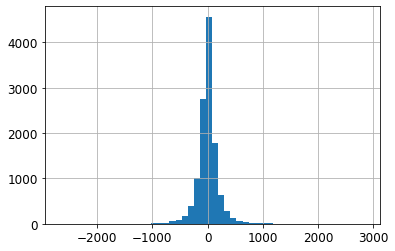

In [4]:
# Definir variação do ativo
market_minute["Variação do ativo"] = market_minute["Fechamento"] - market_minute["Abertura"]

# Histograma
market_minute["Variação do ativo"].hist(bins = 50)
plt.show()

In [5]:
# Visualizar Dataset
market_minute.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Book,IFR (RSI) [9],Spread,Variação do ativo,Unnamed: 15
1,96555.0,96570.0,96405.0,96510.0,96807.75,96634.66,96827.3,97185.59,96429.91,96533.13,96854.87,13037,33.18,-236.55,-45.0,60.0
2,96610.0,96655.0,96535.0,96560.0,96823.75,96665.83,96832.4,97176.04,96471.46,96533.30,96855.04,8271,35.78,-186.55,-50.0,50.0
3,96575.0,96695.0,96530.0,96605.0,96837.25,96692.28,96836.3,97168.12,96506.38,96533.14,96854.89,13216,38.18,-141.55,30.0,45.0
4,96585.0,96675.0,96555.0,96570.0,96854.75,96714.10,96839.0,97171.35,96538.15,96532.76,96854.51,13019,35.18,-176.55,-15.0,35.0
5,96520.0,96600.0,96485.0,96580.0,96865.75,96750.13,96841.0,97156.22,96575.28,96532.38,96854.13,15255,35.62,-166.55,60.0,10.0


In [6]:
# Separação do Dataset em treinamento e teste
from sklearn.model_selection import train_test_split

train_val_set, test_set = train_test_split(market_minute, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)
train_set, val_set = train_test_split(train_val_set, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)

In [7]:
market = train_set.copy()
market = market.reset_index()
val_set = val_set.reset_index()

# Identificar correlação
correlation_matrix = market.corr()
correlation_matrix["Variação do ativo"].sort_values(ascending=False)

Variação do ativo               1.000000
IFR (RSI) [9]                   0.337640
Spread                          0.065748
Unnamed: 15                     0.004108
Fechamento                     -0.000625
Mínima                         -0.006606
Máxima                         -0.006667
Média Móvel E [9]              -0.010681
Média Móvel A [50]             -0.012420
Bandas de Bollinger A [20]     -0.012452
Abertura                       -0.012718
index                          -0.012812
Média Móvel A [20]             -0.012852
VWAP Band                      -0.012902
VWAP D                         -0.012902
Bandas de Bollinger A [20].1   -0.013215
Book                           -0.014547
Name: Variação do ativo, dtype: float64

In [8]:
# Função cálculo de variação
def variacao(coluna_antiga):
    inclinacao = []

    for index in range (0, len(coluna_antiga) - 1):
        x = np.arctan(coluna_antiga[index] - coluna_antiga[index + 1])
        inclinacao.append(x)
    
    coluna_nova = inclinacao
    coluna_nova.append(coluna_nova[len(coluna_nova)-1])
    return coluna_nova

# Definir variação das features
market["Inclinação M20"] = variacao(market["Média Móvel A [20]"])
market["Inclinação M50"] = variacao(market["Média Móvel A [50]"])
market["Inclinação ME9"] = variacao(market["Média Móvel E [9]"])
market["Inclinação VWAP"] = variacao(market["VWAP D"])
market["Inclinação Book"] = variacao(market["Book"])

val_set["Inclinação M20"] = variacao(val_set["Média Móvel A [20]"])
val_set["Inclinação M50"] = variacao(val_set["Média Móvel A [50]"])
val_set["Inclinação ME9"] = variacao(val_set["Média Móvel E [9]"])
val_set["Inclinação VWAP"] = variacao(val_set["VWAP D"])
val_set["Inclinação Book"] = variacao(val_set["Book"])

In [9]:
# Identificar nova correlação
correlation_matrix = market.corr()
correlation_matrix["Variação do ativo"].sort_values(ascending=False)

Variação do ativo               1.000000
Inclinação ME9                  0.391953
IFR (RSI) [9]                   0.337640
Inclinação M20                  0.146577
Inclinação VWAP                 0.145186
Inclinação M50                  0.088719
Spread                          0.065748
Unnamed: 15                     0.004108
Fechamento                     -0.000625
Mínima                         -0.006606
Máxima                         -0.006667
Média Móvel E [9]              -0.010681
Média Móvel A [50]             -0.012420
Bandas de Bollinger A [20]     -0.012452
Abertura                       -0.012718
index                          -0.012812
Média Móvel A [20]             -0.012852
VWAP Band                      -0.012902
VWAP D                         -0.012902
Bandas de Bollinger A [20].1   -0.013215
Book                           -0.014547
Inclinação Book                -0.016867
Name: Variação do ativo, dtype: float64

In [10]:
# Excluindo features não importantes
market.drop(["Média Móvel E [9]", "Média Móvel A [50]", "Média Móvel A [20]", "Book", "index", "VWAP D"], axis=1)
val_set.drop(["Média Móvel E [9]", "Média Móvel A [50]", "Média Móvel A [20]", "Book", "index", "VWAP D"], axis=1)

,Abertura,Máxima,Mínima,Fechamento,Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP Band,IFR (RSI) [9],Spread,Variação do ativo,Unnamed: 15,Inclinação M20,Inclinação M50,Inclinação ME9,Inclinação VWAP,Inclinação Book
0,117721.61,117852.44,117631.04,117661.23,118573.38,117692.53,118490.50,28.31,1303.38,-60.38,130.82,-1.536540,-1.314762,-1.554705,-1.510916,1.570174
1,117958.10,117963.14,117686.39,117721.61,118547.59,117776.69,118507.23,30.36,1328.39,-236.49,60.38,-1.524058,0.099669,-1.554818,-1.498302,1.570721
2,117907.79,118038.61,117847.41,117953.07,118512.10,117854.95,118521.05,40.36,1340.13,45.28,231.46,-1.469313,1.445667,-1.521720,-1.384994,1.570138
3,117993.33,118023.52,117872.56,117902.76,118505.09,117881.58,118526.38,36.31,1333.86,-90.57,50.31,-1.495918,1.398311,-1.544507,-1.375682,-1.570359
4,118078.86,118119.12,117927.91,117993.33,118488.99,117924.35,118531.46,40.73,1376.48,-85.53,90.57,1.054101,1.421317,-1.530657,-1.307512,-1.570702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,111884.14,111939.89,111879.07,111929.75,111964.20,111526.83,111751.43,78.35,1763.85,45.61,10.14,1.520258,1.512857,1.527941,1.467961,-1.569597
1086,111818.25,111899.34,111813.18,111884.14,111945.72,111505.78,111741.70,74.60,1741.08,65.89,45.61,1.549586,1.551642,1.524809,1.520788,1.570707
1087,111843.59,111858.79,111818.25,111848.66,111922.83,111434.40,111721.66,84.22,1762.78,5.07,35.48,1.514486,1.497291,1.501029,1.357634,-1.569694
1088,111848.66,111879.07,111843.59,111848.66,111904.65,111417.10,111717.03,84.22,1712.21,0.00,0.00,1.510154,1.508455,1.514988,1.394703,-1.570246


In [11]:
# Separando feature target
market_labels = market["Variação do ativo"]
market_train = market.drop(["Variação do ativo"], axis = 1)

val_labels = val_set["Variação do ativo"]
val_train = val_set.drop(["Variação do ativo"], axis = 1)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Formatação da Pipeline
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

market_ready = num_pipeline.fit_transform(market_train)
val_ready = num_pipeline.fit_transform(val_train)
market_ready

array([[-1.73187426,  0.13795331,  0.13121293, ..., -1.0069825 ,
        -0.15049817,  1.07206206],
       [-1.73152114,  0.14094225,  0.13584501, ..., -1.00325852,
         0.08644383, -0.93538924],
       [-1.73116802,  0.1390402 ,  0.13802481, ..., -0.99804299,
         0.2345966 ,  1.06895214],
       ...,
       [ 1.73116802,  1.28222345,  1.28085487, ..., -1.00448621,
        -1.07829284, -0.93546118],
       [ 1.73152114,  1.27812154,  1.27948378, ..., -1.01293124,
        -1.12421134, -0.93536492],
       [ 1.73187426,  1.28523141,  1.28332241, ..., -1.01293124,
        -1.12421134, -0.93536492]])

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Modelo de Random Forest
forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)
forest_reg.fit(market_ready, market_labels)

# Seleciona 5 pontos do conjunto de treinamento.
some_data = val_ready
some_labels = val_labels

# Prepara os dados - não se esqueça deste passo.
some_data_prepared = some_data

# Para obter as previsões, basta chamar o método predict()
predicted_labels = forest_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))

# Compare com os valores originais:
print("Original: {}".format(some_labels.values))

Predição: [-318.027 -397.631  -69.224 ... -129.496 -129.496 -127.025]
Original: [ -60.38 -236.49   45.28 ...    5.07    0.      5.07]


A acurácia do modelo é de: 57.8;
O valor total em pontos ganhos é de: 14849.16;
O Payoff é de: 1.28;
A expectativa Matemática é de:1.75.


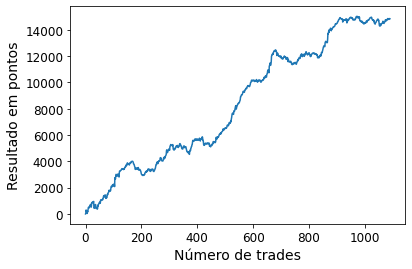

In [14]:
# Função criada para evaluate do modelo
def evaluate(predicao, original):
    acertou_lado = 0
    resultado = 0
    resultado_grafico = [0]
    resultado_trade_a_trade = []
    for index in range(0, len(predicao)):
        resultado_antigo = resultado
        if (predicao[index] >= 0) and (original[index] >= 0):
            acertou_lado += 1
            resultado += original[index]
        elif (predicao[index] < 0) and (original[index] < 0):
            acertou_lado += 1
            resultado += original[index]*(-1)
        else:
            resultado -= abs(original[index])
        resultado_grafico.append(round(resultado,2))
        resultado_trade_a_trade.append(round(resultado-resultado_antigo,2))
        
    acuracia = round((acertou_lado/len(predicao)*100),2)
    resultado = round(resultado,2)
    
    positivos = 0
    total_positivo = 0
    negativos = 0
    total_negativo = 0
    
    for i in resultado_trade_a_trade:
        if i > 0:
            positivos += 1
            total_positivo += i
        else:
            negativos += 1
            total_negativo += i*(-1)
    media_lucro = total_positivo/positivos
    media_perda = total_negativo/negativos
    payoff = round(media_lucro/media_perda,2)
    expectativa_matematica = round((acuracia/100)/(1-(acuracia/100))*payoff,2)
        
    
    return [acuracia,resultado, resultado_grafico, payoff, expectativa_matematica]

acuracia, resultado, resultado_grafico, payoff, expectativa_matematica = evaluate(predicted_labels, some_labels.values)

print("A acurácia do modelo é de: {};\nO valor total em pontos ganhos é de: {};\nO Payoff é de: {};\nA expectativa Matemática é de:{}.".format(acuracia, resultado, payoff, expectativa_matematica))
plt.plot(resultado_grafico)
plt.xlabel("Número de trades")
plt.ylabel("Resultado em pontos")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
forest_rmse = np.sqrt(mean_squared_error(some_labels.values, predicted_labels))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 267.65


In [16]:
from sklearn.model_selection import GridSearchCV
from timeit import default_timer

# Definir GridSearch
param_grid = [
    {'n_estimators': [10, 30], 'max_features': [4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

t1 = default_timer()
grid_search.fit(market_ready, market_labels)
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 12.71 s


In [17]:
# Selecionar os melhores parâmetros
final_model = grid_search.best_estimator_

# Predição com o Modelo + GridSearch
predicted_labels = final_model.predict(some_data_prepared)

In [18]:
forest_rmse = np.sqrt(mean_squared_error(some_labels.values, predicted_labels))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 245.71


A acurácia do modelo é de: 57.89;
O valor total em pontos ganhos é de: 17045.3;
O Payoff é de: 1.34;
A expectativa Matemática é de:1.84.


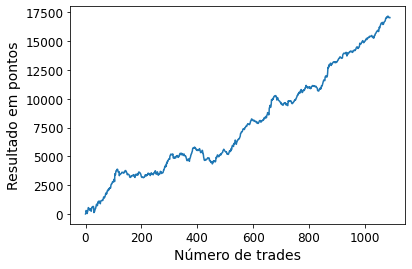

In [19]:
acuracia, resultado, resultado_grafico, payoff, expectativa_matematica = evaluate(predicted_labels, some_labels.values)
print("A acurácia do modelo é de: {};\nO valor total em pontos ganhos é de: {};\nO Payoff é de: {};\nA expectativa Matemática é de:{}.".format(acuracia, resultado, payoff, expectativa_matematica))
plt.plot(resultado_grafico)
plt.xlabel("Número de trades")
plt.ylabel("Resultado em pontos")
plt.show()

Observa-se que a utilização do GridSeach melhorou o modelo, entretando, de maneira pouco significativa. A seguir, a implementação de uma Rede Neural Recorrente. Espera-se um melhor resultado.

# Rede Neural Recorrente

## Primeiro Modelo

In [20]:
# Definir Dataset
market_minute = load_market_data(MARKET_FILE, SHEET_NAME)
market_minute = market_minute.drop(["Unnamed: 15"], axis = 1)

market_minute.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Book,IFR (RSI) [9],Spread,Variação do ativo
0,96510.0,96620.0,96490.0,96570.0,96794.75,96621.73,96824.2,97186.28,96403.22,96533.25,96855.00,9467,39.15,-176.55,NaN
1,96555.0,96570.0,96405.0,96510.0,96807.75,96634.66,96827.3,97185.59,96429.91,96533.13,96854.87,13037,33.18,-236.55,-60.0
2,96610.0,96655.0,96535.0,96560.0,96823.75,96665.83,96832.4,97176.04,96471.46,96533.30,96855.04,8271,35.78,-186.55,50.0
3,96575.0,96695.0,96530.0,96605.0,96837.25,96692.28,96836.3,97168.12,96506.38,96533.14,96854.89,13216,38.18,-141.55,45.0
4,96585.0,96675.0,96555.0,96570.0,96854.75,96714.10,96839.0,97171.35,96538.15,96532.76,96854.51,13019,35.18,-176.55,-35.0


In [21]:
# Ajustar valores extremos
market_minute.loc[market_minute["Variação do ativo"] > 500, "Variação do ativo"] = 500
market_minute.loc[market_minute["Variação do ativo"] < -500, "Variação do ativo"] = -500

# Inserir feature target
market_minute["target"] = market_minute["Fechamento"].shift(-1)
market_minute = market_minute.dropna()
market_minute.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Book,IFR (RSI) [9],Spread,Variação do ativo,target
1,96555.0,96570.0,96405.0,96510.0,96807.75,96634.66,96827.3,97185.59,96429.91,96533.13,96854.87,13037,33.18,-236.55,-60.0,96560.0
2,96610.0,96655.0,96535.0,96560.0,96823.75,96665.83,96832.4,97176.04,96471.46,96533.30,96855.04,8271,35.78,-186.55,50.0,96605.0
3,96575.0,96695.0,96530.0,96605.0,96837.25,96692.28,96836.3,97168.12,96506.38,96533.14,96854.89,13216,38.18,-141.55,45.0,96570.0
4,96585.0,96675.0,96555.0,96570.0,96854.75,96714.10,96839.0,97171.35,96538.15,96532.76,96854.51,13019,35.18,-176.55,-35.0,96580.0
5,96520.0,96600.0,96485.0,96580.0,96865.75,96750.13,96841.0,97156.22,96575.28,96532.38,96854.13,15255,35.62,-166.55,10.0,96515.0


In [22]:
# Separando feature target
X = market_minute.drop(columns = ["target", "Fechamento"]).values
Y = market_minute["target"].values
X.shape, Y.shape

((12112, 14), (12112,))

In [23]:
# Separar dataset em treino, validade e teste
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)
X_val, X_test , y_val, y_test = train_test_split(X_val,y_val, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)

In [24]:
# Reshape o dataset
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
y_train = y_train.reshape((y_train.shape[0],1))

X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],1))

X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10900, 14, 1), (10900, 1), (1090, 14, 1), (1090, 1))

In [25]:
# Definir modelo LSTM
model = keras.models.Sequential([
    keras.layers.LSTM(20, activation = "relu", input_shape = [None,1],return_sequences=True),
    keras.layers.LSTM(20, activation = "relu",return_sequences=True),
    keras.layers.LSTM(40, activation = "relu",return_sequences=True),
    keras.layers.LSTM(80, activation = "relu",return_sequences=True),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 40)          9760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 80)          38720     
_________________________________________________________________
dense (Dense)                (None, None, 1)           81        
Total params: 53,601
Trainable params: 53,601
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Treinar modelo uilizando Adam como optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer="adam")
modelfit = model.fit(X_train, y_train, epochs=100, batch_size = 128, validation_data = (X_val, y_val))

Train on 10900 samples, validate on 1090 samples
Epoch 1/100
10900/10900 [==============================] - 10s 928us/sample - loss: 7941878904.0617 - val_loss: 7963002905.3651
Epoch 2/100
10900/10900 [==============================] - 4s 368us/sample - loss: 5666472056.4374 - val_loss: 5423598240.6459
Epoch 3/100
10900/10900 [==============================] - 4s 376us/sample - loss: 4728757948.8294 - val_loss: 5482274603.6844
Epoch 4/100
10900/10900 [==============================] - 4s 400us/sample - loss: 3685965546.8624 - val_loss: 4031901914.8917
Epoch 5/100
10900/10900 [==============================] - 4s 404us/sample - loss: 3375830199.5684 - val_loss: 4605082145.8202
Epoch 6/100
10900/10900 [==============================] - 5s 423us/sample - loss: 3237420892.3479 - val_loss: 3765492627.9633
Epoch 7/100
10900/10900 [==============================] - 5s 425us/sample - loss: 2430109926.6818 - val_loss: 2628207336.0440
Epoch 8/100
10900/10900 [==============================] - 5s

10900/10900 [==============================] - 5s 420us/sample - loss: 244652.3515 - val_loss: 182726.8607
Epoch 67/100
10900/10900 [==============================] - 5s 417us/sample - loss: 235816.7828 - val_loss: 174545.3279
Epoch 68/100
10900/10900 [==============================] - 4s 366us/sample - loss: 227167.0846 - val_loss: 165696.6360
Epoch 69/100
10900/10900 [==============================] - 4s 366us/sample - loss: 219190.5349 - val_loss: 157432.0622
Epoch 70/100
10900/10900 [==============================] - 4s 380us/sample - loss: 211463.1138 - val_loss: 150490.7848
Epoch 71/100
10900/10900 [==============================] - 4s 388us/sample - loss: 204159.2420 - val_loss: 144531.0346
Epoch 72/100
10900/10900 [==============================] - 4s 407us/sample - loss: 264195.2130 - val_loss: 307623.2080
Epoch 73/100
10900/10900 [==============================] - 4s 404us/sample - loss: 210784.4334 - val_loss: 134600.1696
Epoch 74/100
10900/10900 [===========================

In [27]:
# Evaluate modelo
model.evaluate(X_val, y_val)

1090/1090 [==============================] - 0s 373us/sample - loss: 87188.3484


87188.3483944954

In [28]:
# Predição dos dados teste
y_pred = model.predict(X_test)[:, -1]

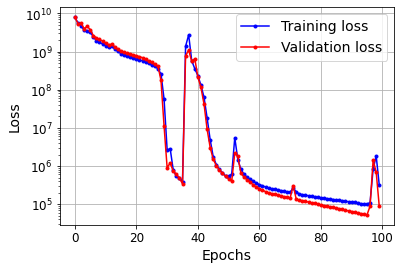

In [29]:
plt.plot(np.arange(len(modelfit.history["loss"])), modelfit.history["loss"], "b.-", label="Training loss")
plt.plot(np.arange(len(modelfit.history["val_loss"])), modelfit.history["val_loss"], "r.-", label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

In [30]:
# Ajuste para comparar variação do fechamento do ativo
variacao_pred = []
for i in range(len(y_pred)-1):
    dif = y_pred[i][0] - y_pred[i+1][0]
    variacao_pred.append(dif)
    
variacao_test = []
for i in range(len(y_pred)-1):
    dif = y_test[i][0] - y_test[i+1][0]
    variacao_test.append(dif)

A acurácia do modelo é de: 85.12;
O valor total em pontos ganhos é de: 7617.73;
O Payoff é de: 1.71;
A expectativa Matemática é de:9.78.


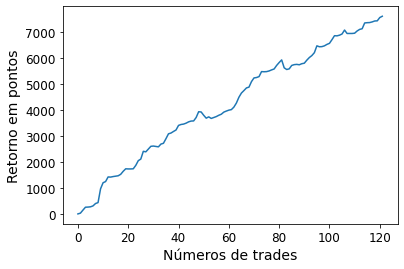

In [31]:
acuracia, resultado, resultado_grafico, payoff, expectativa_matematica = evaluate(variacao_pred, variacao_test)
print("A acurácia do modelo é de: {};\nO valor total em pontos ganhos é de: {};\nO Payoff é de: {};\nA expectativa Matemática é de:{}.".format(acuracia, resultado, payoff, expectativa_matematica))
plt.plot(resultado_grafico)
plt.xlabel("Números de trades")
plt.ylabel("Retorno em pontos")
plt.show()

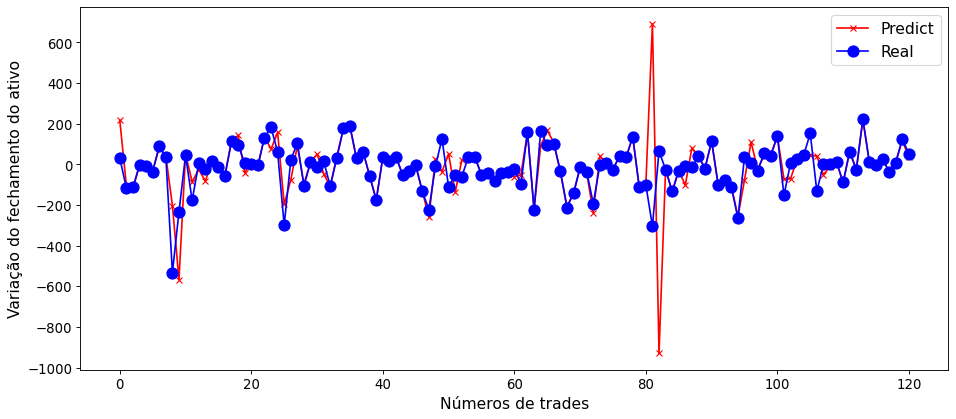

In [32]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(variacao_pred)), variacao_pred, "rx-", label="Predict")
plt.plot(range(len(variacao_test)), variacao_test, "bo-", label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Variação do fechamento do ativo")
plt.legend(fontsize=14)

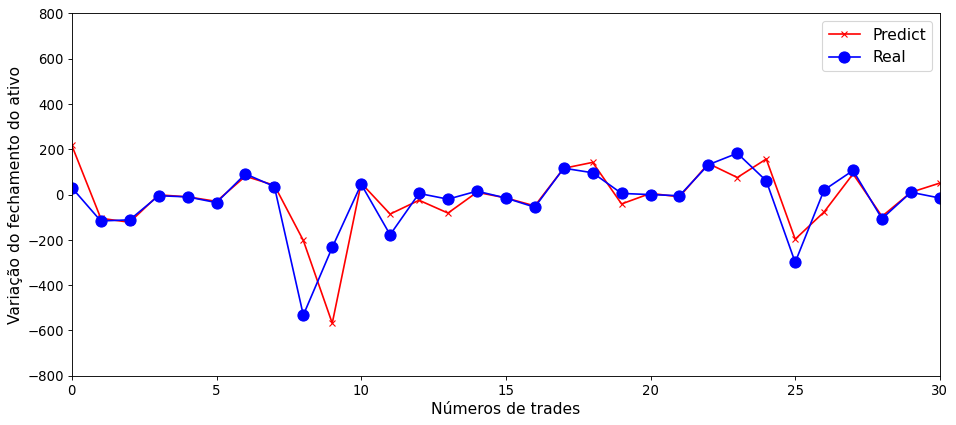

In [33]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(variacao_pred)), variacao_pred, "rx-", label="Predict")
plt.plot(range(len(variacao_test)), variacao_test, "bo-", label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Variação do fechamento do ativo")
plt.axis([0, 30,-800,800])
plt.legend(fontsize=14)

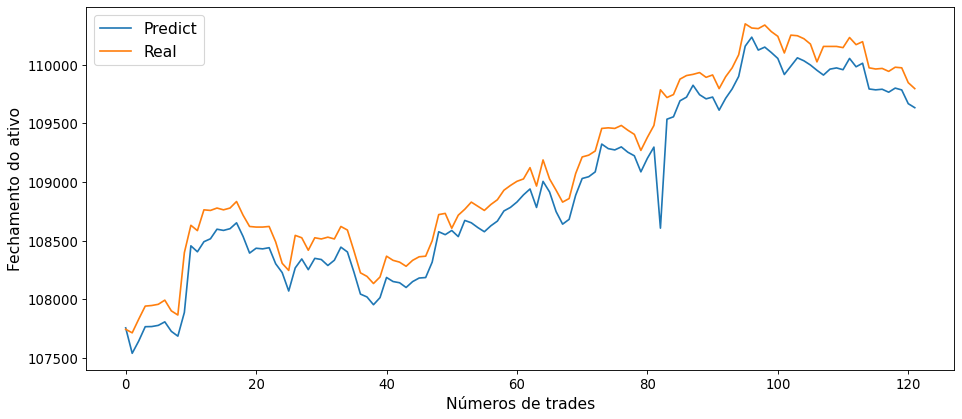

In [34]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(y_pred)), y_pred, label="Predict")
plt.plot(range(len(y_test)), y_test, label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Fechamento do ativo")
#plt.axis([0, n_steps + ahead, -1, 1])
plt.legend(fontsize=14)

Testando o modelo com outro conjunto de dados nunca antes inseridos no jupyter

In [35]:
# Importar dataset
MARKET_FILE = 'Dataset_Teste.xlsx'
SHEET_NAME = '5minutos'
def load_market_data(market_file, sheet):
    return pd.read_excel(market_file,sheet)

teste = load_market_data(MARKET_FILE, SHEET_NAME)
teste.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Negócios,IFR (RSI) [9],Spread [WINFUT - IBOV],Variação do ativo
0,95620,95705,95600,95685,95423.75,95553.13,95617.3,95739.07,95108.43,96160.68,96481.19,9431,68.13,349.04,-115
1,95525,95650,95520,95615,95419.50,95520.16,95627.0,95722.68,95116.32,96162.35,96482.85,11738,63.37,279.04,-70
2,95540,95560,95510,95530,95418.25,95496.45,95638.4,95718.39,95118.11,96164.65,96485.16,4327,56.33,194.04,-85
3,95555,95575,95520,95540,95420.25,95488.06,95654.1,95723.85,95116.65,96165.66,96486.18,6720,57.49,204.04,10
4,95490,95560,95480,95550,95421.50,95475.08,95671.0,95727.26,95115.74,96167.27,96487.79,8472,58.56,214.04,10


In [36]:
# Ajustes do dataset
teste.loc[teste["Variação do ativo"] > 500, "Variação do ativo"] = 500
teste.loc[teste["Variação do ativo"] < -500, "Variação do ativo"] = -500

# Inserir feature target
teste["target"] = teste["Fechamento"].shift(-1)
teste = teste.dropna()

In [37]:
# Definir feature target
X_teste = teste.drop(columns = ["target", "Fechamento"]).values
Y_teste = teste["target"].values

In [38]:
# Reshape dataset
X_teste = X_teste.reshape((X_teste.shape[0],X_teste.shape[1],1))
Y_teste = Y_teste.reshape((Y_teste.shape[0],1))

In [39]:
# Predição do novo conjunto de dados
Y_prediction= model.predict(X_teste)[:, -1]

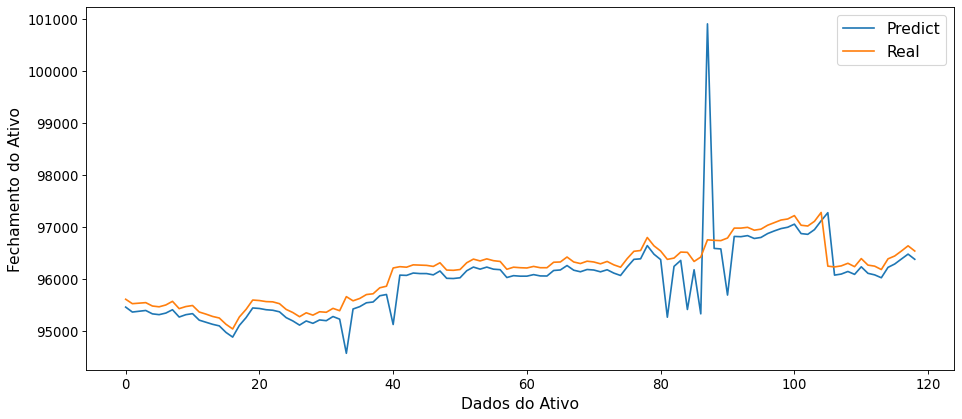

In [40]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(Y_prediction)), Y_prediction, label="Predict")
plt.plot(range(len(Y_teste)), Y_teste, label="Real", markersize=10)
plt.xlabel("Dados do Ativo")
plt.ylabel("Fechamento do Ativo")
plt.legend(fontsize=14)

Após o resultado, foi questionado a organização dos dados para o treinamento do modelo: Em um uso prático do modelo no mercado de ativos, durante o intervalo de tempo atual, há dados sobre sua Abertura, mas não sobre sua Máxima, Minima e Fechamento. Sendo assim, no modelo 2, foi realizado um Shift de todas as features,exceto Abertura.

## Modelo 2

In [41]:
# Definir Dataset
MARKET_FILE = 'Dataset.xlsx'
SHEET_NAME = '5minutos'
def load_market_data(market_file, sheet):
    return pd.read_excel(market_file,sheet)

market_minute = load_market_data(MARKET_FILE, SHEET_NAME)
market_minute = market_minute.drop(["Unnamed: 15"], axis = 1)

market_minute.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Book,IFR (RSI) [9],Spread,Variação do ativo
0,96510.0,96620.0,96490.0,96570.0,96794.75,96621.73,96824.2,97186.28,96403.22,96533.25,96855.00,9467,39.15,-176.55,NaN
1,96555.0,96570.0,96405.0,96510.0,96807.75,96634.66,96827.3,97185.59,96429.91,96533.13,96854.87,13037,33.18,-236.55,-60.0
2,96610.0,96655.0,96535.0,96560.0,96823.75,96665.83,96832.4,97176.04,96471.46,96533.30,96855.04,8271,35.78,-186.55,50.0
3,96575.0,96695.0,96530.0,96605.0,96837.25,96692.28,96836.3,97168.12,96506.38,96533.14,96854.89,13216,38.18,-141.55,45.0
4,96585.0,96675.0,96555.0,96570.0,96854.75,96714.10,96839.0,97171.35,96538.15,96532.76,96854.51,13019,35.18,-176.55,-35.0


In [42]:
market_minute.loc[market_minute["Variação do ativo"] > 500, "Variação do ativo"] = 500
market_minute.loc[market_minute["Variação do ativo"] < -500, "Variação do ativo"] = -500

abertura = market_minute["Abertura"]
market_minute = market_minute.shift(-1)
market_minute["Abertura"] = abertura
market_minute["target"] = market_minute["Fechamento"]
market_minute = market_minute.dropna()

In [43]:
market_minute.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Book,IFR (RSI) [9],Spread,Variação do ativo,target
0,96510.0,96570.0,96405.0,96510.0,96807.75,96634.66,96827.3,97185.59,96429.91,96533.13,96854.87,13037.0,33.18,-236.55,-60.0,96510.0
1,96555.0,96655.0,96535.0,96560.0,96823.75,96665.83,96832.4,97176.04,96471.46,96533.30,96855.04,8271.0,35.78,-186.55,50.0,96560.0
2,96610.0,96695.0,96530.0,96605.0,96837.25,96692.28,96836.3,97168.12,96506.38,96533.14,96854.89,13216.0,38.18,-141.55,45.0,96605.0
3,96575.0,96675.0,96555.0,96570.0,96854.75,96714.10,96839.0,97171.35,96538.15,96532.76,96854.51,13019.0,35.18,-176.55,-35.0,96570.0
4,96585.0,96600.0,96485.0,96580.0,96865.75,96750.13,96841.0,97156.22,96575.28,96532.38,96854.13,15255.0,35.62,-166.55,10.0,96580.0


In [44]:
# Separando feature target
X = market_minute.drop(columns = ["target", "Fechamento"]).values
Y = market_minute["target"].values
X.shape, Y.shape

((12112, 14), (12112,))

In [45]:
# Separar dataset em treino, validade e teste
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)
X_val, X_test , y_val, y_test = train_test_split(X_val,y_val, test_size=0.1, random_state=RANDOM_SEED, shuffle = False)

In [46]:
# Reshape o dataset
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
y_train = y_train.reshape((y_train.shape[0],1))

X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],1))

X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10900, 14, 1), (10900, 1), (1090, 14, 1), (1090, 1))

In [47]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, activation = "relu", input_shape = [None,1],return_sequences=True),
    keras.layers.LSTM(20, activation = "relu",return_sequences=True),
    keras.layers.LSTM(40, activation = "relu",return_sequences=True),
    keras.layers.LSTM(80, activation = "relu",return_sequences=True),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 40)          9760      
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 80)          38720     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           81        
Total params: 53,601
Trainable params: 53,601
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Treinar modelo uilizando Adam como optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer="adam")
modelfit = model.fit(X_train, y_train, epochs=100, batch_size = 128, validation_data = (X_val, y_val))

Train on 10900 samples, validate on 1090 samples
Epoch 1/100
10900/10900 [==============================] - 11s 1ms/sample - loss: 6706965468.3009 - val_loss: 6716784099.8165
Epoch 2/100
10900/10900 [==============================] - 5s 458us/sample - loss: 5023592605.4517 - val_loss: 5696135603.9046
Epoch 3/100
10900/10900 [==============================] - 5s 490us/sample - loss: 4425681956.6385 - val_loss: 5342905504.6459
Epoch 4/100
10900/10900 [==============================] - 5s 418us/sample - loss: 3927925604.8029 - val_loss: 4166989190.8110
Epoch 5/100
10900/10900 [==============================] - 4s 409us/sample - loss: 3104037469.3813 - val_loss: 3502527033.3064
Epoch 6/100
10900/10900 [==============================] - 4s 394us/sample - loss: 2432473468.1013 - val_loss: 2664727870.4734
Epoch 7/100
10900/10900 [==============================] - 4s 395us/sample - loss: 2016992727.2279 - val_loss: 2385718203.4202
Epoch 8/100
10900/10900 [==============================] - 5s 4

10900/10900 [==============================] - 5s 431us/sample - loss: 37869363.9501 - val_loss: 37098937.9009
Epoch 66/100
10900/10900 [==============================] - 4s 390us/sample - loss: 26323139.2932 - val_loss: 26985364.9725
Epoch 67/100
10900/10900 [==============================] - 4s 405us/sample - loss: 19566701.0965 - val_loss: 20235181.9083
Epoch 68/100
10900/10900 [==============================] - 4s 393us/sample - loss: 14967180.4154 - val_loss: 15350236.0257
Epoch 69/100
10900/10900 [==============================] - 4s 403us/sample - loss: 11430941.0620 - val_loss: 11490297.9505
Epoch 70/100
10900/10900 [==============================] - 5s 422us/sample - loss: 8634945.1980 - val_loss: 8442650.6055
Epoch 71/100
10900/10900 [==============================] - 5s 440us/sample - loss: 6443904.2776 - val_loss: 6113603.8202
Epoch 72/100
10900/10900 [==============================] - 5s 457us/sample - loss: 4757503.8239 - val_loss: 4314584.7679
Epoch 73/100
10900/10900 [=

In [49]:
# Predição dos dados teste
y_pred = model.predict(X_test)[:, -1]

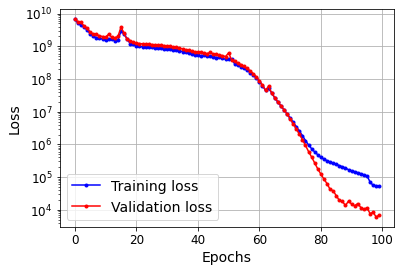

In [50]:
plt.plot(np.arange(len(modelfit.history["loss"])), modelfit.history["loss"], "b.-", label="Training loss")
plt.plot(np.arange(len(modelfit.history["val_loss"])), modelfit.history["val_loss"], "r.-", label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

In [51]:
# Ajuste para comparar variação do fechamento do ativo
variacao_pred = []
for i in range(len(y_pred)-1):
    dif = y_pred[i][0] - y_pred[i+1][0]
    variacao_pred.append(dif)
    
variacao_test = []
for i in range(len(y_pred)-1):
    dif = y_test[i][0] - y_test[i+1][0]
    variacao_test.append(dif)

A acurácia do modelo é de: 79.34;
O valor total em pontos ganhos é de: 7708.94;
O Payoff é de: 2.86;
A expectativa Matemática é de:10.98.


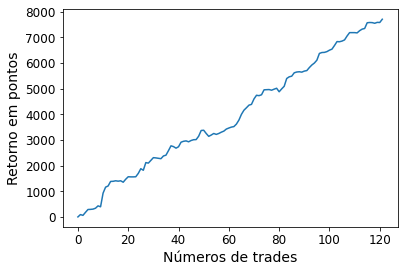

In [52]:
acuracia, resultado, resultado_grafico, payoff, expectativa_matematica = evaluate(variacao_pred, variacao_test)
print("A acurácia do modelo é de: {};\nO valor total em pontos ganhos é de: {};\nO Payoff é de: {};\nA expectativa Matemática é de:{}.".format(acuracia, resultado, payoff, expectativa_matematica))
plt.plot(resultado_grafico)
plt.xlabel("Números de trades")
plt.ylabel("Retorno em pontos")
plt.show()

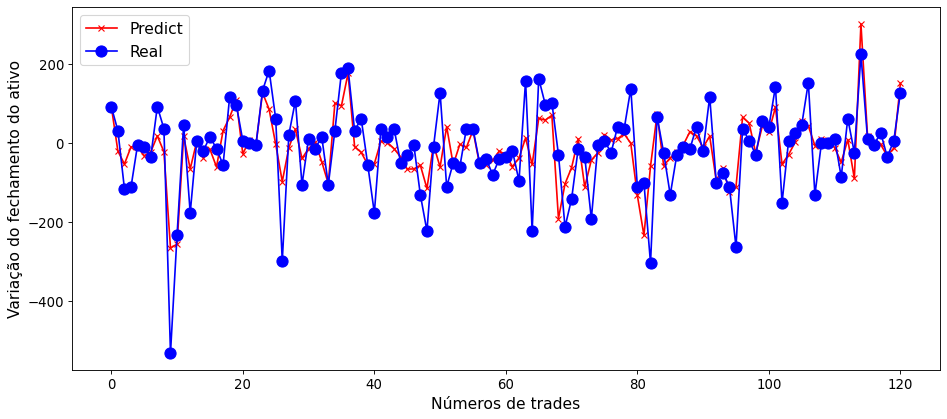

In [53]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(variacao_pred)), variacao_pred, "rx-", label="Predict")
plt.plot(range(len(variacao_test)), variacao_test, "bo-", label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Variação do fechamento do ativo")
plt.legend(fontsize=14)

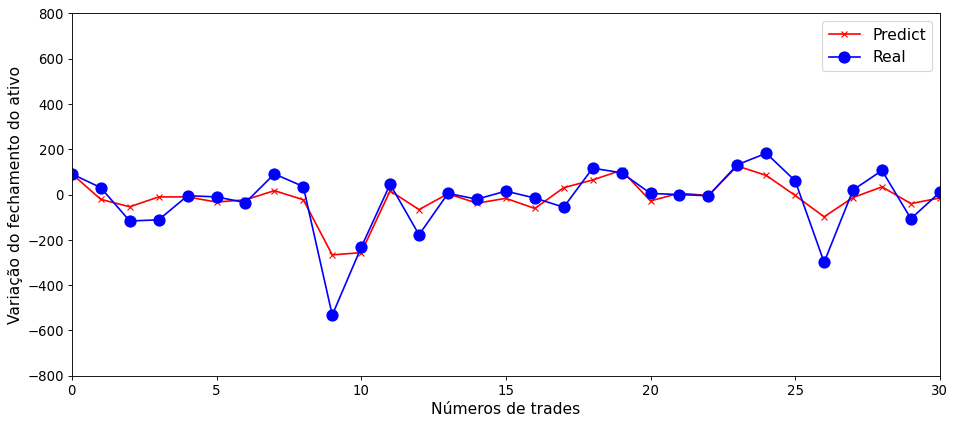

In [54]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(variacao_pred)), variacao_pred, "rx-", label="Predict")
plt.plot(range(len(variacao_test)), variacao_test, "bo-", label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Variação do fechamento do ativo")
plt.axis([0, 30,-800,800])
plt.legend(fontsize=14)

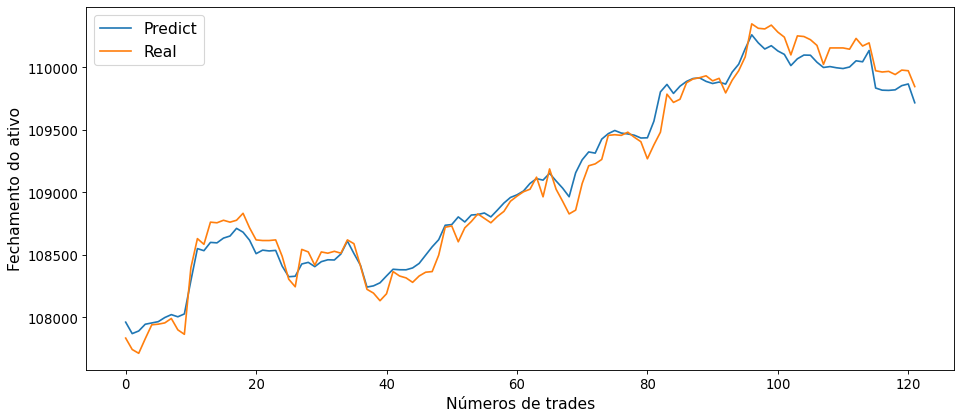

In [55]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(y_pred)), y_pred, label="Predict")
plt.plot(range(len(y_test)), y_test, label="Real", markersize=10)
plt.xlabel("Números de trades")
plt.ylabel("Fechamento do ativo")
#plt.axis([0, n_steps + ahead, -1, 1])
plt.legend(fontsize=14)

Relizando o mesmo teste realizado no Primeiro Modelo com os novos dados de teste:

In [65]:
# Importar dataset
MARKET_FILE = 'Dataset_Teste.xlsx'
SHEET_NAME = '5minutos'
def load_market_data(market_file, sheet):
    return pd.read_excel(market_file,sheet)

teste = load_market_data(MARKET_FILE, SHEET_NAME)
teste.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Negócios,IFR (RSI) [9],Spread [WINFUT - IBOV],Variação do ativo
0,95620,95705,95600,95685,95423.75,95553.13,95617.3,95739.07,95108.43,96160.68,96481.19,9431,68.13,349.04,-115
1,95525,95650,95520,95615,95419.50,95520.16,95627.0,95722.68,95116.32,96162.35,96482.85,11738,63.37,279.04,-70
2,95540,95560,95510,95530,95418.25,95496.45,95638.4,95718.39,95118.11,96164.65,96485.16,4327,56.33,194.04,-85
3,95555,95575,95520,95540,95420.25,95488.06,95654.1,95723.85,95116.65,96165.66,96486.18,6720,57.49,204.04,10
4,95490,95560,95480,95550,95421.50,95475.08,95671.0,95727.26,95115.74,96167.27,96487.79,8472,58.56,214.04,10


In [66]:
# Ajustes do dataset
teste.loc[market_minute["Variação do ativo"] > 500, "Variação do ativo"] = 500
teste.loc[market_minute["Variação do ativo"] < -500, "Variação do ativo"] = -500

abertura = teste["Abertura"]
teste = teste.shift(-1)
teste["Abertura"] = abertura
teste["target"] = teste["Fechamento"]
teste = teste.dropna()

In [67]:
teste.head()

,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [20],Média Móvel E [9],Média Móvel A [50],Bandas de Bollinger A [20],Bandas de Bollinger A [20].1,VWAP D,VWAP Band,Negócios,IFR (RSI) [9],Spread [WINFUT - IBOV],Variação do ativo,target
0,95620,95650.0,95520.0,95615.0,95419.50,95520.16,95627.0,95722.68,95116.32,96162.35,96482.85,11738.0,63.37,279.04,-70.0,95615.0
1,95525,95560.0,95510.0,95530.0,95418.25,95496.45,95638.4,95718.39,95118.11,96164.65,96485.16,4327.0,56.33,194.04,-85.0,95530.0
2,95540,95575.0,95520.0,95540.0,95420.25,95488.06,95654.1,95723.85,95116.65,96165.66,96486.18,6720.0,57.49,204.04,10.0,95540.0
3,95555,95560.0,95480.0,95550.0,95421.50,95475.08,95671.0,95727.26,95115.74,96167.27,96487.79,8472.0,58.56,214.04,10.0,95550.0
4,95490,95510.0,95420.0,95485.0,95420.50,95456.35,95687.0,95724.70,95116.30,96169.30,96489.83,8591.0,53.58,149.04,-65.0,95485.0


In [68]:
# Definir feature target
X_teste = teste.drop(columns = ["target", "Fechamento"]).values
Y_teste = teste["target"].values

In [69]:
# Reshape Dataset
X_teste = X_teste.reshape((X_teste.shape[0],X_teste.shape[1],1))
Y_teste = Y_teste.reshape((Y_teste.shape[0],1))

In [70]:
# Predição dos dados teste
Y_prediction= model.predict(X_teste)[:, -1]

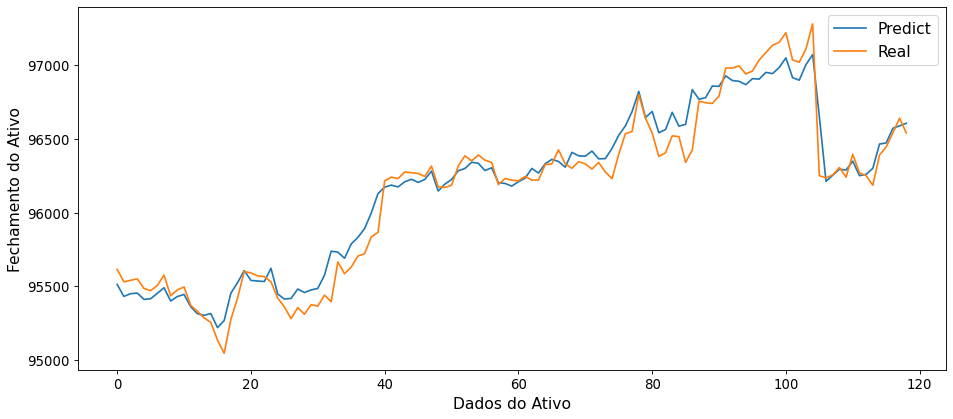

In [71]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(Y_prediction)), Y_prediction, label="Predict")
plt.plot(range(len(Y_teste)), Y_teste, label="Real", markersize=10)
plt.xlabel("Dados do Ativo")
plt.ylabel("Fechamento do Ativo")
plt.legend(fontsize=14)